# RL coursework, part IV (30 pts in total)

---

**Name:** Your Name

**SN:** Your Student Number

---

**Due date:** *April 10th, 2025*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part4.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

----
**Reminder of copyrights**

Copyrights protect this code/content and distribution or usages of it (or parts of it) without permission is prohibited. This includes uploading it and usage of it in training in any LLMs systems.

### Objectives

#### Q.1: You will implement a number of off-policy multi-step return estimates, and answer questions about their accuracy.

#### Q.2: You will be looking at other, TD-like, updates to learn the value function. You will be asked to investigate different properties of these: e.g. convergence properties, variance of updates. This is akin to a typical analysis one would undertaken when proposing a new update rule to learn value functions.


## Imports

In [44]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)

## Section A: Multi-step + offpolicy in practice [11 points total]
For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necessary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency.

In [49]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  del pi
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))

  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

### Q 1.1 [5 points]
Implement the return functions below and run the cells below that.

In [52]:

def full_importance_weights(pi, mu):
    """
    Compute full-trajectory importance sampling weights for each timestep,

    Returns a list rho such that:
    rho[t] = product of pi[k]/mu[k] for k = t to T-1
    """
    T = len(pi)
    rho = [0.0] * T  # initialize output list
    product = 1.0
    for t in reversed(range(T)):
        product *= pi[t] / mu[t]
        rho[t] = product
    return rho

def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with full importance-sampling corrections, so that
  the return G_t is corrected with the full importance-sampling correction of
  the rest of the trajectory.
  """

  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  rho = full_importance_weights(pi, mu)

  for t in reversed(range(T)):
    if t == T - 1:
      G[t] = r[t] + d[t] * v[t + 1]
    else:
      G[t] = r[t] + d[t] * ((1 - l) * v[t + 1] + l * G[t + 1])
  v = v[:-1]
  return (1 - l) * v + l * G * rho


def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with per-decision importance-sampling corrections.
  """
  T = len(rewards) 
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  
  rho = pi/mu # no need for full_importance_weights function.

  for t in reversed(range(T)):
    if t == T - 1:
      G[t] = rho[t]*(r[t] + d[t]*v[t + 1])
    else:
      G[t] = rho[t]*(r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1]))
  v = v[:-1]  
  return (1 - l)*v + l*G


def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with
  1. per-decision importance-sampling corrections, and
  2. control variates
  """
  T = len(rewards) 
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  rho = pi/mu
  for t in reversed(range(T)):
    if t == T-1:
      G[t] = rho[t]*(r[t] + (d[t]*v[t + 1])) + (1-rho[t])*v[t]
    else:
      G[t] = rho[t]*(r[t] + (d[t]*((1-l)*v[t+1] + l*G[t+1]))) + (1-rho[t])*v[t]
  v = v[:-1]  
  return (1 - l)*v + l*G


def compute_adaptive_lambdas(pi, mu, l):
    """
    Compute lambda_t = lambda * min(1, 1 / rho_t) for each t.
    """
    T = len(pi)
    rho = [pi[t] / mu[t] for t in range(T)]
    adaptive_lambdas = []
    for t in range(T):
        scaling = min(1.0, 1.0 / rho[t])
        adaptive_lambdas.append(l * scaling)
    return adaptive_lambdas

def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with
  1. per-decision importance-sampling corrections, and
  2. control variates, and
  3. adaptive bootstrapping.

  Implement the adaptive bootstrapping with an additional trace parameter
  lambda, such that lambda_t = lambda * min(1, 1/rho_t).
  """
  T = len(rewards)  
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  rho = [pi[t] / mu[t] for t in range(T)]
  lmbda = compute_adaptive_lambdas(pi, mu, l)
  for t in reversed(range(T)):
    if t == T-1:
      G[t] = lmbda[t]*rho[t]*(r[t] + d[t]*v[t + 1]) + (1-(lmbda[t]*rho[t]))*v[t]
    else:
      G[t] = lmbda[t]*rho[t]*(r[t] + (d[t]*((1-l)*v[t+1] + l*G[t+1]))) + (1-(lmbda[t]*rho[t]))*v[t]
  v = v[:-1] 
  return (1 - l)*v + l*G



In [53]:
#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...

  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=int)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state

  # in this case, observations are just the real states
  observations = states

  # generate rewards
  rewards     = 2.*actions - 1. # -1 for left, +1 for right,
  rewards[-1] = np.sum(actions)  # extra final reward for going right

  # compute discounts
  discounts     = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0

  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities

  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2)
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1)
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward



[ 19.89  698.906 207.781   6.678   0.657]


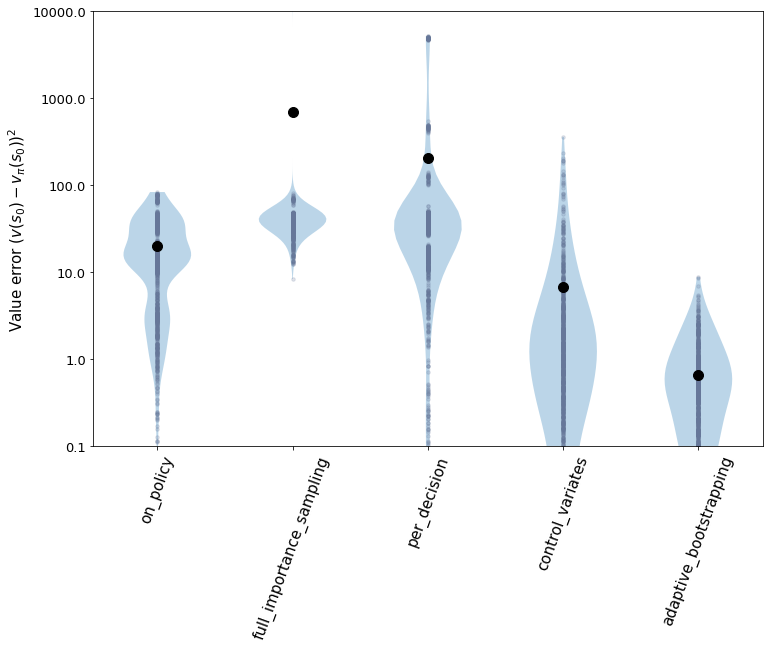

In [54]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision', 'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    errors[-1].append((estimate[0] - v0)**2)
print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 1.2 [3 points]
Explain the ranking in terms of value error of the different return estimates.

The ranking of value error in terms of increasing performance: 

### Full importance sampling: 

This is the worst off-policy estimate. Full importance sampling performs poorly because it multiplies all the per-step importance ratios, which can produce extreme values when a single ratio is very high or very low. This amplification of outlier weights—where rare actions under the behavior policy but common under the target policy, or vice versa, create very high or low ratios—leads to return estimates with enormous variance. Consequently, the few extreme values skew the average return far from most individual estimates, resulting in unstable and unreliable performance.

### Per Decision Importance Sampling: 

This is the 2nd worst off-policy estimate. Per-decision importance sampling mitigates—but does not completely eliminate—the outlier problem seen in full importance sampling. By applying the importance weight correction at each individual step rather than multiplying weights across the entire trajectory, the influence of an extremely high or low ratio is confined to that particular step rather than being compounded throughout the return estimate. This “per-step” correction reduces the overall variance compared to full importance sampling, but because each step can still be affected by outlier ratios, the method remains less stable than approaches that further control these effects

### On policy: 

On policy is in the middle in terms of performance. This is the only estimate which avoids reweighting. This leads to lower variance than per decision sampling. However, the on-policy method is not as exploratory as other off-policy methods which leads to its lack of performance compared to the next two best performers.

### Control Variates: 

This is the 2nd best off-policy estimate. The control variates method incorporates a baseline value—specifically, the term (1-\rho[t])v[t]—to counterbalance the effects of extreme importance weights. This extra term essentially “pulls” the return estimate toward the stable value function v[t], thereby reducing the overall variance caused by outlier importance ratios. By tempering the impact of these extreme weights, the method achieves a much more reliable and stable return estimate. This variance reduction is significant enough that, among off-policy methods, control variates become the first to consistently outperform even the on-policy estimates.

### Adaptive Bootstrapping: 

Adaptive bootstrapping recognizes that when an action is rare under the behavior policy but common under the target policy, the resulting importance weight can be extreme. This leads to high variance and potential bias because such samples are not well-explored. To address this, the algorithm adapts the bootstrapping factor—essentially relying more on the estimated value  v[t]  rather than the sampled return—in these cases. By almost fully bootstrapping on these “rare” samples, it reduces the undue influence of high-variance estimates, thereby lowering both bias and variance. This dynamic adjustment results in the best performance among off-policy methods, offering the lowest variance overall.




### Q 1.3 [3 points]
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

While adaptive bootstrapping exhibits the lowest variance in simulations, there are several reasons one might not choose it for off-policy learning. First, it relies on aggressive bootstrapping for rare state-action pairs, which—when combined with function approximation—can risk divergence, especially in more complex or high-dimensional environments. Second, the method’s added complexity and sensitivity to hyperparameters (e.g., trace parameters and importance sampling thresholds) might not be justified in simple environments with short trajectories, where simpler methods can perform comparably without incurring extra computational overhead. Finally, if the behavior policy is already similar to the target policy, the benefit of off-policy corrections diminishes, and the additional bias introduced by adaptive bootstrapping could hinder exploration and long-term learning.

## Section B: Potential different algorithms/updates [19 points total]
 Consider a MDP $M = (\mathbb{S}, \mathbb{A}, p, r, \gamma)$ and a behaviour policy $\mu$. We use policy $\mu$ to generate trajectories of experience:
\begin{equation*}
    (s_{t}, a_{t}, r_{t},s_{t+1}, a_{t+1}, r_{t+1},\cdots, s_{t+n-1}, a_{t+n-1}, r_{t+n-1}, s_{t+n}, a_{t+n}) \,.
\end{equation*}
Note that this is an $n$-step sequence, starting from time $t$.

Given these partial trajectories we consider the following learning problems:




### Q2.1 [9 points]
Consider a learning update based on the following temporal difference error:
$$\delta_t = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t)$$

Consider updating a tabular action value function with TD.

i) **Does the resulting value function converge, under any initialisation of the value function? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove the convergence under infinity number of interactions with this MDP, under fixed behaviour policy $\mu$ and show its convergence point. If not, show why it diverges. (7 points)**

We have a two-step TD update:

$$
\delta_t = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t),
$$

which corresponds to an operator $T^{(2)}$ acting on $q$.

- Defining the Operators $T$ and $T^{(2)}$:

- One-step Bellman Optimality Operator $T$:

For any state–action pair $(s,a)$,

$$
(Tq)(s,a) = \mathbb{E}\Bigl[ R(s,a) + \gamma \max_{a’} q(s’,a’) \Big| S=s, A=a \Bigr].
$$
2.	**Two-step Operator $T^{(2)}$**:
    
We define;

$$
T^{(2)} = T \circ T,
$$

i.e.,

$$
(T^{(2)}q)(s,a) = \mathbb{E}\Bigl[ R(s,a) + \gamma R(s’, a’) + \gamma^2\max_{a’’} q(s’’,a’’) \Big| S=s, A=a \Bigr].
$$
This matches the two-step lookahead in our TD update.

3. **Showing $T$ is a $\gamma$-Contraction in the Max Norm:**

One can show that for any two action-value functions $q_1$ and $q_2$,

$$
|Tq_1 - Tq_2|_\infty \le \gamma,
$$

$$
|q_1 - q_2|_\infty.
$$

The proof involves:

•	Expanding the difference $(Tq_1 - Tq_2)(s,a)$ in terms of the expectation over rewards plus the term involving $\gamma,\max_{a’},q$.
    
•	Bounding the difference by $\gamma,|q_1 - q_2|_\infty$.

Since $\gamma < 1$, $T$ is a contraction mapping in the $|\cdot|_\infty$ (max) norm.

4. **$T^{(2)}$ is a $\gamma^2$-Contraction:**

Since $T$ is a $\gamma$-contraction, we have

$$
|T^{(2)}q_1 - T^{(2)}q_2|_\infty = |T(Tq_1) - T(Tq_2)|_\infty \le \gamma,
$$

$$
|Tq_1 - Tq_2|_\infty \le \gamma \cdot \gamma,
$$

$$
|q_1 - q_2|_\infty = \gamma^2,|q_1 - q_2|_\infty.
$$

Thus, $T^{(2)}$ is a strict contraction (with contraction constant $\gamma^2$) and therefore has a unique fixed point by Banach’s Fixed Point Theorem.

5. **Fixed Point of $T^{(2)}$ is the Optimal $Q^*$ :**

	•	The unique fixed point of the one-step Bellman optimality operator $T$ is the optimal action-value function $Q^*$.
    
	•	Consequently, the unique fixed point of $T^{(2)} = T \circ T$ is also $Q^*$.

Intuitively, repeatedly applying $T^{(2)}$ to any initial $q$ will converge to $Q^*$.

6. **Stochastic Approximation Convergence:**

When implementing the two-step update,

$$
q(S_t, A_t) \leftarrow q(S_t, A_t) + \alpha_t\delta_t,
$$

this corresponds to a stochastic approximation of $T^{(2)}$. Under standard conditions:

-	Sufficient Exploration: The behavior policy $\mu$ visits every state–action pair infinitely often.

-	Robbins–Monro Conditions: The learning rates ${\alpha_t}$ satisfy
$$
\sum_{t=0}^\infty \alpha_t = \infty \quad \text{and} \quad \sum_{t=0}^\infty \alpha_t^2 < \infty.
$$

**Finite MDP and $\gamma < 1$: This ensures a well-defined fixed point and bounded returns**.

Under these assumptions, the stochastic approximation converges almost surely to the fixed point of $T^{(2)}$, i.e., $Q^*$.

7. **Conclusion**

•	The detailed proof shows that $T$ is a $\gamma$-contraction in the max norm, implying that $T^{(2)}$ is a $\gamma^2$-contraction.

•	By Banach’s Fixed Point Theorem, $T^{(2)}$ has a unique fixed point, which is $Q^*$.

•	The two-step TD update, implemented via stochastic approximation, converges almost surely to $Q^*$ under the standard conditions of sufficient exploration, appropriate learning rates, and a finite MDP.

Thus, no matter the initial $q(s,a)$, the update converges to $Q^*$ given an infinite number of interactions with the MDP.

ii) **Under which conditions, would the above process converge to the optimal value function $q*$ ? (2 points)**


For the process to converge to the optimal action-value function $q$*, the following conditions must be met:

1.	**Sufficient Exploration**: Every state–action pair must be visited infinitely often. This ensures that the behavior policy provides enough coverage of the state–action space to learn accurate values. The behavior policy must be GLIE — meaning it must explore every state–action pair infinitely often while eventually becoming greedy. This guarantees that the policy’s actions converge to those that maximize the action-value function, leading to the optimal $q$* in the tabular case.

2.	**Appropriate Learning Rates (Robbins–Monro Conditions):** The step sizes $\alpha_t$ must satisfy

$$
\sum_{t=0}^\infty \alpha_t = \infty \quad \text{and} \quad \sum_{t=0}^\infty \alpha_t^2 < \infty,
$$
ensuring that the updates eventually stabilize.

3.	**Finite MDP with $\gamma$ < 1**: A finite state–action space and a discount factor $\gamma$ strictly less than 1 guarantee that the Bellman operator (and its multi-step versions) is a contraction, leading to a unique fixed point $q$*.

### Q2.2 [10 points]

Consider the same questions now for the following temporal difference error
\begin{equation}
        \delta_t = r(S_{t},A_{t}) + \gamma \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} \left[ r(S_{t+1},A_{t+1}) + \gamma \max_{a} q(S_{t+2},a) \right] - q(S_t, A_t)
\end{equation}

where $\pi(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathbb{A} \times \mathbb{S}$ and consider the behaviour policy to be either:

  a. $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathbb{A} \times \mathbb{S}$,
  
  b. $\mu(a|s) = \frac{1}{|\mathbb{A}|}$ (uniformly random policy).

Answer the below two questions for **both choices** of the behaviour policy $\mu$:
* i)  Does updating a tabular action value function with this TD error converge to the optimal value function $q_*$? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove this convergence under infinity number of interaction with this MDP, under behaviour policy $\mu$. If not, show why it diverges or alternatively convergence to a different solution. (4 points)
* ii) How does the variance of this update compare to the one induced by the error in Q2.1? (3 points).
* iii) Can you propose a different behaviour policy that achieves a lower variance than any of the choices we considered for $\mu$ (a and b)? Prove that your behaviour policy achieve this. Argue why, if that is not possible. (3 points)

*Answer here:*

 **Does updating a tabular action value function with this TD error converge to the optimal value function  𝑞∗
 ? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove this convergence under infinity number of interaction with this MDP, under behaviour policy  𝜇
 . If not, show why it diverges or alternatively convergence to a different solution. (4 points)**
 


We consider the following TD error:

$$
\delta_t = r(S_{t},A_{t}) + \gamma \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} \left[ r(S_{t+1},A_{t+1}) + \gamma \max_{a} q(S_{t+2},a) \right] - q(S_t, A_t),
$$

where $\pi(a|s) \in \arg\max_a,q(s,a)$ for all $s,a$, and answer whether updating a tabular action-value function with this TD error converges to the optimal value function $q_*$ under two different behavior policies.

### (a): Greedy Behavior Policy

If the behavior policy $\mu$ is greedy,

$$
\mu(a|s) \in \arg\max_a q(s,a),
$$

then $\mu$ coincides with the target policy $\pi$. In this situation, the importance sampling ratio

$$
\frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})}
$$

is equal to 1, so the TD error becomes

$$
\delta_t = r(S_t,A_t) + \gamma \left[ r(S_{t+1},A_{t+1}) + \gamma \max_a,q(S_{t+2},a) \right] - q(S_t,A_t).
$$

However, since both the target and behavior policies are greedy, the behavior policy lacks exploration. In off-policy learning (and even in standard Q-learning), sufficient exploration is crucial for convergence to $q$. With a greedy behavior policy, many state–action pairs may never be visited, so the update process may converge to a suboptimal value function rather than $q$. In summary, under a purely greedy behavior policy, the process fails to guarantee convergence to the optimal value function due to the lack of infinite exploration.

### (b): Uniform Random Behavior Policy

If the behavior policy is uniformly random,

$$
\mu(a|s) = \frac{1}{|\mathbb{A}|},
$$

then every action in every state is selected with equal probability. The target policy $\pi$ remains greedy, so

$$
\pi(a|s)=
\begin{cases}
1, & \text{if } a\in\arg\max_a,q(s,a), \
0, & \text{otherwise.}
\end{cases}
$$

Thus, the importance sampling ratio becomes

$$
\frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} =
\begin{cases}
|\mathbb{A}|, & \text{if } A_{t+1} \text{ is the greedy action}, \
0, & \text{otherwise}.
\end{cases}
$$

Although this ratio can be large (or zero) for individual transitions, the behavior policy’s uniform randomness guarantees infinite exploration — every state–action pair is visited infinitely often in the limit. In expectation, the correction factor behaves correctly (since the greedy action is sampled with probability $1/|\mathbb{A}|$, leading to an expected ratio of 1). Thus, under the Robbins–Monro conditions (i.e., appropriate learning rates) and assuming the MDP is finite with $\gamma < 1$, the stochastic approximation will converge to the unique fixed point of the Bellman operator (or its multi-step variant), which is the optimal action-value function $q_*$.


**ii) How does the variance of this update compare to the one induced by the error in Q2.1? (3 points).**


In Q2.1, the TD error is
$$
\delta_t = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t),
$$
so the variance is driven solely by the randomness in the rewards and transitions.
	•	In the new update,
$$
\delta_t = r(S_t,A_t) + \gamma \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} \left[ r(S_{t+1},A_{t+1}) + \gamma \max_{a} q(S_{t+2},a) \right] - q(S_t, A_t),
$$
the second reward (and the subsequent bootstrapped term) is scaled by the factor
$$
\frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})}.
$$
•	When the behavior policy is greedy (or matches the target), this ratio is 1 and both updates have similar variance.

•	When the behavior policy is more exploratory (e.g., uniformly random), the ratio can be quite large (or zero) on individual samples. For instance, if $\mu(a|s)=\frac{1}{|\mathbb{A}|}$ while $\pi$ is greedy, then with probability $\frac{1}{|\mathbb{A}|}$ the ratio is $|\mathbb{A}|$, and with probability $1-\frac{1}{|\mathbb{A}|}$ it is 0. This leads to occasional large corrections that dramatically increase the variance of the update.

Thus, the new update generally has higher variance than the Q2.1 update due to the multiplicative importance sampling factor, unless the behavior policy is identical to the target (in which case the ratio is always 1).

***Can you propose a different behaviour policy that achieves a lower variance than any of the choices we considered for $\mu$ (a and b)? Prove that your behaviour policy achieve this. Argue why, if that is not possible. (3 points)***

We can ask whether there exists a behavior policy $\mu$ that leads to lower variance than the ones we considered. Recall that the importance sampling ratio is given by

$$
\rho(a|s) = \frac{\pi(a|s)}{\mu(a|s)}.
$$

For actions that are not greedy under the target policy (i.e. when $\pi(a|s)=0$), the ratio is zero regardless of $\mu$. For greedy actions (i.e. when $\pi(a|s)=1$), we have

$$
\rho(a|s) = \frac{1}{\mu(a|s)}.
$$

To minimize variance, we would like the importance sampling ratio to be as close to 1 as possible. In particular, for the greedy actions we need

$$
\frac{1}{\mu(a|s)} \approx 1,
$$

or equivalently,

$$
\mu(a|s) \approx 1.
$$

Since $\mu(\cdot|s)$ is a probability density function over actions, the maximum value it can assign to any single action is 1. This ideal situation is achieved when

$$
\mu(a|s) = \pi(a|s),
$$

which means that the behavior policy is exactly equal to the target policy. In that case, $\rho(a|s)=1$ for all $s$ and $a$, and the variance induced by the importance sampling ratio is minimized.

However, if $\mu$ is identical to $\pi$, then the behavior policy is greedy and does not guarantee infinite exploration. In practice, to ensure sufficient exploration we must use a behavior policy that is different from $\pi$ (for example, an $\epsilon$-greedy variant). Any deviation from $\mu=\pi$ will necessarily lead to $\rho(a|s)$ being greater than 1 for some actions, and hence higher variance.

Conclusion:


The best possible (i.e. minimum variance) behavior policy is $\mu=\pi$, since in that case the importance sampling ratio is exactly 1. However, because $\mu=\pi$ does not allow for exploration, any practical behavior policy must introduce some difference between $\mu$ and $\pi$, which in turn increases the variance. Therefore, there is no behavior policy that achieves a lower variance than $\mu=\pi$ while still ensuring adequate exploration.


